<a href="https://colab.research.google.com/github/pratimakandel/CV_Recycling/blob/master/Recycling_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#import all the libraries


import keras
import os
import time 
import cv2
import numpy as np
from keras import layers
from keras import models
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization
from keras.applications import MobileNet
from keras.applications import InceptionV3
from keras.applications.mobilenet import preprocess_input
from keras.callbacks import ModelCheckpoint, CSVLogger
from IPython.display import Image
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


In [2]:
#You can download the picture in your drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r /content/drive/My\ Drive/data/validation/ /content/
!cp -r /content/drive/My\ Drive/data/train/ /content/

In [ ]:
#VGG16 model

from keras.applications import VGG16

base_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv_dw_13':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in base_model.layers:
	print("{}: {}".format(layer, layer.trainable))

In [ ]:
#testing freezing model 
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
opt = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Let's create our model
model.compile(loss='categorical_crossentropy',
               optimizer= opt,
               metrics=['accuracy'])

In [ ]:
n_classes = 3
img_width, img_height = 150, 150
train_data_dir = '/content/train'
validation_data_dir = '/content/validation'
nb_train_samples = 1278 #75750
nb_validation_samples = 115 #25250
batch_size = 35

train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    color_mode = 'rgb',
    seed = 32,
    class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    color_mode = 'rgb',
    seed = 32,
    class_mode='categorical')

Found 2031 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((35, 150, 150, 3), (35, 4))

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  
  f.write(labels)

{'garbage': 0, 'glass': 1, 'metal': 2, 'plastic': 3}


In [ ]:
!cat labels.txt

garbage
glass
metal
plastic

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=20,
      validation_data=validation_generator,
      validation_steps=len(validation_generator))
model.save('drive/My Drive/test/testing.h5') 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
59/59 [==============================] - 506s 9s/step - loss: 1.0423 - accuracy: 0.5416 - val_loss: 0.8754 - val_accuracy: 0.6138
Epoch 2/20
59/59 [==============================] - 504s 9s/step - loss: 0.7279 - accuracy: 0.7036 - val_loss: 0.6452 - val_accuracy: 0.7276
Epoch 3/20
59/59 [==============================] - 506s 9s/step - loss: 0.6515 - accuracy: 0.7341 - val_loss: 0.6300 - val_accuracy: 0.7439
Epoch 4/20
59/59 [==============================] - 507s 9s/step - loss: 0.5908 - accuracy: 0.7563 - val_loss: 0.5389 - val_accuracy: 0.7805
Epoch 5/20
59/59 [==============================] - 507s 9s/step - loss: 0.5569 - accuracy: 0.7706 - val_loss: 0.5688 - val_accuracy: 0.7683
Epoch 6/20
59/59 [==============================] - 501s 8s/step - loss: 0.5500 - accuracy: 0.7735 - val_loss: 0.6216 - val_accuracy: 0.7317
Epoch 7/20
59/59 [==============================] - 504s 9s/step - loss: 0.497

In [ ]:
#Fine tuning 
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=20,
      validation_data=validation_generator,
      validation_steps=len(validation_generator))
model.save('drive/My Drive/test/testing.h5') 

Epoch 1/20
59/59 [==============================] - 503s 9s/step - loss: 0.2686 - accuracy: 0.9000 - val_loss: 0.5241 - val_accuracy: 0.7886
Epoch 2/20
59/59 [==============================] - 505s 9s/step - loss: 0.2515 - accuracy: 0.9138 - val_loss: 0.5299 - val_accuracy: 0.8089
Epoch 3/20
59/59 [==============================] - 505s 9s/step - loss: 0.2587 - accuracy: 0.9060 - val_loss: 0.5214 - val_accuracy: 0.8089
Epoch 4/20
59/59 [==============================] - 507s 9s/step - loss: 0.2504 - accuracy: 0.9124 - val_loss: 0.5115 - val_accuracy: 0.8049
Epoch 5/20
59/59 [==============================] - 506s 9s/step - loss: 0.2513 - accuracy: 0.9104 - val_loss: 0.5148 - val_accuracy: 0.8049
Epoch 6/20
59/59 [==============================] - 508s 9s/step - loss: 0.2414 - accuracy: 0.9163 - val_loss: 0.5136 - val_accuracy: 0.8089
Epoch 7/20
59/59 [==============================] - 504s 9s/step - loss: 0.2493 - accuracy: 0.9040 - val_loss: 0.5109 - val_accuracy: 0.8049
Epoch 8/20
59

[[0. 0. 1. 0.]]
2


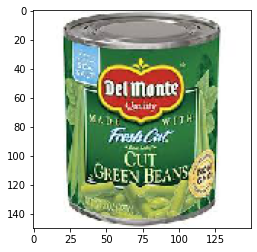

In [ ]:
#To test the model with a single image 
#Use the function below to test muliple images at once 

loaded_model = load_model('drive/My Drive/test/testing.h5')
image_path="drive/My Drive/test/can2.jpeg"
img = image.load_img(image_path, target_size=(150, 150))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
pred = loaded_model.predict(img)
index = np.argmax(pred)
np.set_printoptions(suppress=True)
print(pred)
print(index)


In [8]:
data = []

In [9]:
for filename in os.listdir("drive/My Drive/test/"):
    if filename.endswith("jpg"): 
        img = image.load_img("drive/My Drive/test/" + filename, target_size=(150, 150))
        data.append(img)

In [10]:
from google.colab.patches import cv2_imshow
def predict_class(model, images, show = True):
  for img in images:
    loaded_model = load_model(model)
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)                                           
    pred = loaded_model.predict(img)
    index = np.argmax(pred)
    cv2_imshow(img[0])
    if index == 0:
      print('Unknown\n')
    elif index == 1:
      print('glass\n')
    elif index == 2:
      print('metal\n')
    elif index == 3:
      print('plastic\n')  

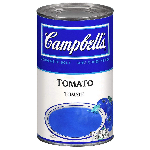

metal



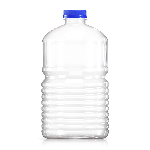

plastic



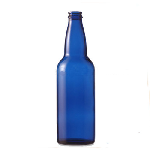

plastic



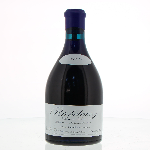

glass



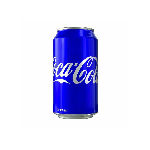

metal



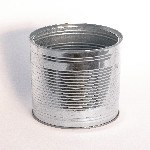

metal



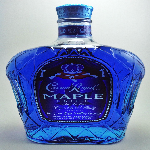

glass



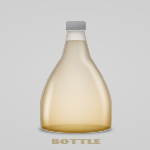

glass



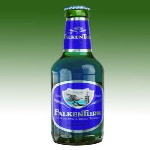

glass



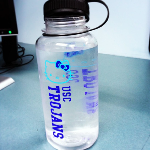

plastic



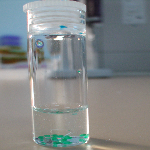

glass



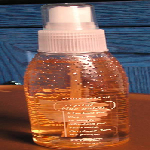

glass



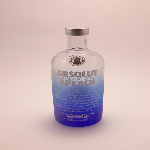

plastic



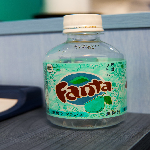

plastic



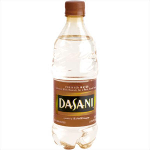

plastic



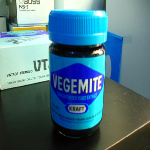

plastic



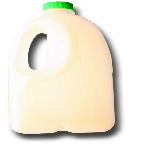

plastic



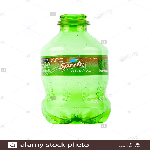

plastic



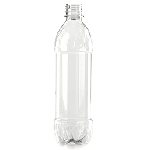

plastic



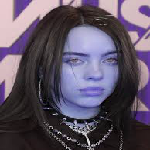

plastic



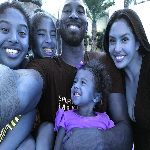

Unknown



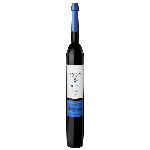

plastic



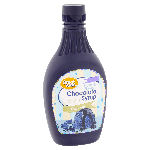

plastic



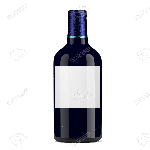

glass



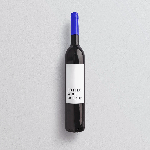

glass



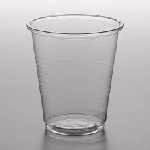

metal



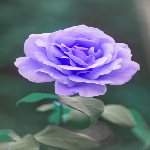

Unknown



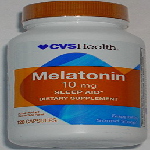

plastic



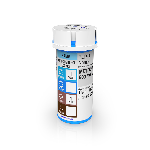

plastic



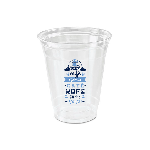

plastic



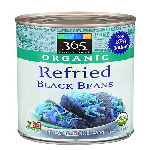

plastic



In [11]:
predict_class('drive/My Drive/test/testing.h5', data)

In [ ]:
#Convert model to Tensorflow lite

saved_model_dir = 'drive/My Drive/save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
from google.colab import files                                                      

files.download('model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>